# AUTO1 Group – Junior Business Analyst Case Study

### Table of Contents

1. [Data Overview and Preparation](#data-overview-and-preparation)
2. [Exploratory Analysis (Python)](#exploratory-analysis-python)
3. [SQL Analysis Layer](#sql-analysis-layer)
4. [Summary and Key Takeaways](#summary-and-key-takeaways)
5. [Data Export (SQL Views for Tableau and CSV for Google Sheets)](#data-export-sql-views-for-tableau-and-csv-for-google-sheets)
6. [Tableau Dashboard](#tableau-dashboard)
7. [Next Steps and Recommendations](#next-steps-and-recommendations)


Project Overview

This notebook is part of the AUTO1 Inventory Performance case study.
It walks through data cleaning, SQL logic and exploratory analysis in Python, leading to a Tableau dashboard summarizing sales performance, margins and pricing insights.
All related files (database, SQL scripts, visuals and dashboard) are included in the project folder for easy reference.

## Data Overview and Preparation

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "Inventory Management Business Case data - Sheet1.csv"

df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

print("Data loaded successfully.")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

display(df.head(3))


Data loaded successfully.
Shape: (1000, 9)
Columns: ['car_unique_id', 'first_online_date', 'car_sold_on_date', 'manufacturer', 'model', 'fuel_type', 'buy_price', 'last_available_online_price', 'external_market_reference_price']


,car_unique_id,first_online_date,car_sold_on_date,manufacturer,model,fuel_type,buy_price,last_available_online_price,external_market_reference_price
0,1234768090,2024-10-17,2024-11-18,Volkswagen,T6 Multivan,Diesel,35031.0,43688,43895.0
1,1258374660,2024-11-26,NaN,MINI,MINI,Benzin,11504.0,16623,15321.0
2,1272940076,2024-10-01,2024-12-07,Mitsubishi,Eclipse Cross,Benzin,13899.0,18422,17831.0


In [ ]:

df["first_online_date"] = pd.to_datetime(df["first_online_date"], errors="coerce")
df["car_sold_on_date"] = pd.to_datetime(df["car_sold_on_date"], errors="coerce")

for col in ["buy_price", "last_available_online_price", "external_market_reference_price"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print(df.dtypes)
print("\nMissing values per column:")
print(df.isna().sum())


car_unique_id                               int64
first_online_date                  datetime64[ns]
car_sold_on_date                   datetime64[ns]
manufacturer                               object
model                                      object
fuel_type                                  object
buy_price                                 float64
last_available_online_price                 int64
external_market_reference_price           float64
dtype: object

Missing values per column:
car_unique_id                        0
first_online_date                    0
car_sold_on_date                   544
manufacturer                         0
model                                0
fuel_type                            0
buy_price                            4
last_available_online_price          0
external_market_reference_price      5
dtype: int64


In [ ]:
df["is_sold"] = df["car_sold_on_date"].notna()

snapshot_date = pd.Timestamp.today().normalize()
df["days_on_market"] = (df["car_sold_on_date"].fillna(snapshot_date) - df["first_online_date"]).dt.days

# gross margin and margin percentage
df["gross_margin_eur"] = df["last_available_online_price"] - df["buy_price"]
df["gross_margin_pct"] = np.where(df["buy_price"] > 0,
                                  df["gross_margin_eur"] / df["buy_price"],
                                  np.nan)

# price gap vs external market reference
df["price_gap_vs_market_eur"] = df["last_available_online_price"] - df["external_market_reference_price"]
df["price_gap_vs_market_pct"] = np.where(df["external_market_reference_price"] > 0,
                                         df["price_gap_vs_market_eur"] / df["external_market_reference_price"],
                                         np.nan)

df[["is_sold", "days_on_market", "gross_margin_eur", "gross_margin_pct", "price_gap_vs_market_pct"]].head()


,is_sold,days_on_market,gross_margin_eur,gross_margin_pct,price_gap_vs_market_pct
0,True,32,8657.0,0.247124,-0.004716
1,False,340,5119.0,0.444976,0.084981
2,True,67,4523.0,0.325419,0.033145
3,True,46,5205.0,0.610772,0.032571
4,False,361,5030.0,0.434971,-0.011144


## Exploratory Analysis (Python)


In [ ]:
total_cars = len(df)
sold_cars = df["is_sold"].sum()
sell_through_rate = sold_cars / total_cars
avg_days_to_sell = df.loc[df["is_sold"], "days_on_market"].mean()
avg_margin_pct = df["gross_margin_pct"].mean()
avg_price_gap_pct = df["price_gap_vs_market_pct"].mean()

summary = pd.DataFrame({
    "Metric": [
        "Total cars",
        "Cars sold",
        "Sell-through rate",
        "Average days to sell (sold cars)",
        "Average gross margin %",
        "Average price gap vs market %"
    ],
    "Value": [
        total_cars,
        sold_cars,
        f"{sell_through_rate:.1%}",
        f"{avg_days_to_sell:.1f}",
        f"{avg_margin_pct:.1%}",
        f"{avg_price_gap_pct:.1%}"
    ]
})

display(summary)


,Metric,Value
0,Total cars,1000
1,Cars sold,456
2,Sell-through rate,45.6%
3,Average days to sell (sold cars),40.1
4,Average gross margin %,39.6%
5,Average price gap vs market %,-1.0%


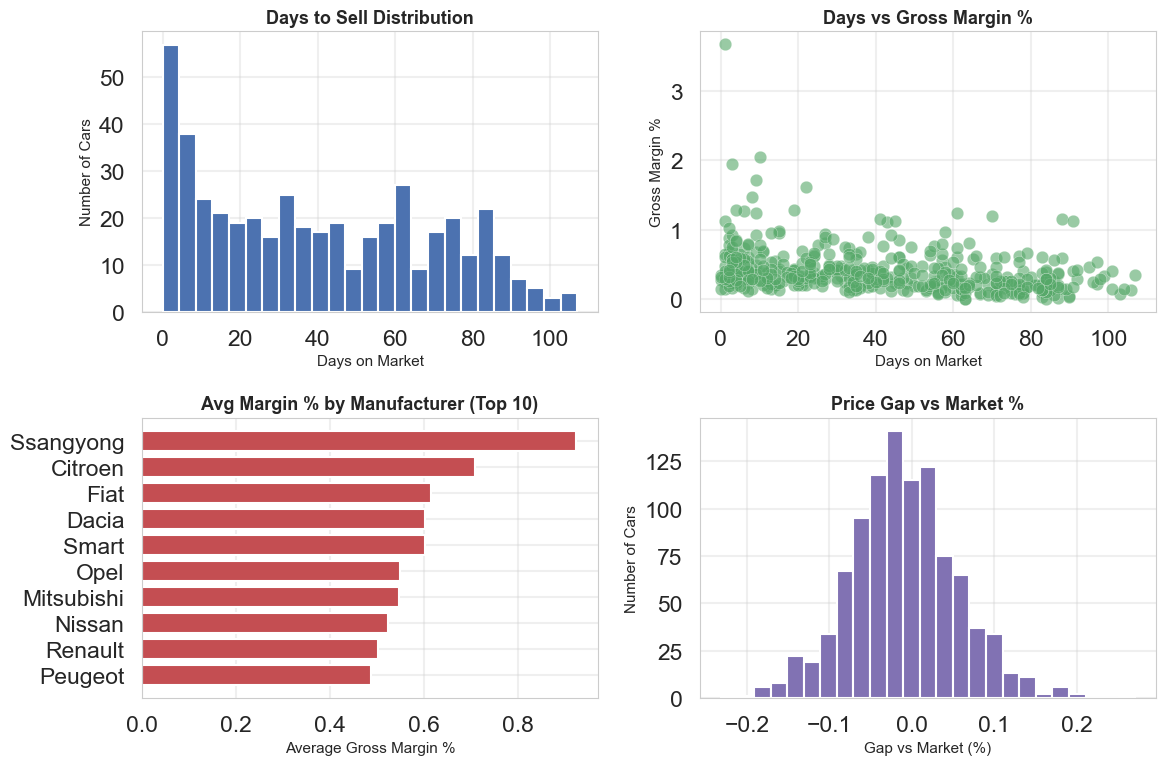

Saved: auto1_visual_summary.png


In [17]:
import seaborn as sns
sns.set_style("whitegrid")

sold_df = df[df["is_sold"]].copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Days to sell distribution (sold cars)
axes[0, 0].hist(sold_df["days_on_market"].dropna(), bins=25, color="#4C72B0")
axes[0, 0].set_title("Days to Sell Distribution")
axes[0, 0].set_xlabel("Days on Market")
axes[0, 0].set_ylabel("Number of Cars")

# Days vs Gross Margin % (sold cars)
axes[0, 1].scatter(
    sold_df["days_on_market"], sold_df["gross_margin_pct"],
    alpha=0.6, color="#55A868", edgecolors="w", linewidths=0.3
)
axes[0, 1].set_title("Days vs Gross Margin %")
axes[0, 1].set_xlabel("Days on Market")
axes[0, 1].set_ylabel("Gross Margin %")

# Avg margin % by manufacturer (Top 10)
by_manu = (
    df.groupby("manufacturer", dropna=False)
      .agg(avg_margin_pct=("gross_margin_pct", "mean"))
      .sort_values("avg_margin_pct", ascending=False)
      .head(10)
)
axes[1, 0].barh(by_manu.index, by_manu["avg_margin_pct"], color="#C44E52")
axes[1, 0].invert_yaxis()
axes[1, 0].set_title("Avg Margin % by Manufacturer (Top 10)")
axes[1, 0].set_xlabel("Average Gross Margin %")

# Price gap vs market distribution
axes[1, 1].hist(df["price_gap_vs_market_pct"].dropna(), bins=25, color="#8172B3")
axes[1, 1].set_title("Price Gap vs Market %")
axes[1, 1].set_xlabel("Gap vs Market (%)")
axes[1, 1].set_ylabel("Number of Cars")

plt.tight_layout()
plt.show()

fig.savefig("auto1_visual_summary.png", dpi=300, bbox_inches="tight")
print("Saved: auto1_visual_summary.png")


## SQL Analysis Layer

In [13]:

import sqlite3

conn = sqlite3.connect("auto1_inventory.db")
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS inventory (
    car_unique_id INTEGER PRIMARY KEY,
    first_online_date DATE,
    car_sold_on_date DATE,
    manufacturer TEXT,
    model TEXT,
    fuel_type TEXT,
    buy_price REAL,
    last_available_online_price REAL,
    external_market_reference_price REAL
);
""")

df.to_sql("inventory", conn, if_exists="replace", index=False)

cur.execute("CREATE INDEX IF NOT EXISTS idx_inventory_dates ON inventory(first_online_date, car_sold_on_date);")
cur.execute("CREATE INDEX IF NOT EXISTS idx_inventory_manu ON inventory(manufacturer);")
cur.execute("CREATE INDEX IF NOT EXISTS idx_inventory_fuel ON inventory(fuel_type);")
conn.commit()

row_count = cur.execute("SELECT COUNT(*) FROM inventory;").fetchone()[0]
print(f"SQLite ready. Rows loaded: {row_count}")


SQLite ready. Rows loaded: 1000


In [ ]:
kpis_sql = """
WITH base AS (
  SELECT
    car_unique_id,
    first_online_date,
    car_sold_on_date
  FROM inventory
)
SELECT
  COUNT(*) AS total_cars,
  SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) AS sold_cars,
  ROUND(100.0 * SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 1) AS sell_through_rate_pct,
  ROUND(AVG(julianday(car_sold_on_date) - julianday(first_online_date)), 1) AS avg_days_to_sell
FROM base
WHERE car_sold_on_date IS NOT NULL;
"""
total_sql = """
SELECT
  COUNT(*) AS total_cars,
  SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) AS sold_cars,
  ROUND(100.0 * SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 1) AS sell_through_rate_pct
FROM inventory;
"""

kpis = cur.execute(kpis_sql).fetchone()
overall = cur.execute(total_sql).fetchone()

print("KPI Summary (SQL):")
print(f"  Total cars: {overall[0]}")
print(f"  Sold cars: {overall[1]}")
print(f"  Sell-through rate: {overall[2]}%")
print(f"  Average days to sell (sold only): {kpis[3]}")


KPI Summary (SQL):
  Total cars: 1000
  Sold cars: 456
  Sell-through rate: 45.6%
  Average days to sell (sold only): 40.1


In [ ]:
snapshot = max(
    pd.Timestamp.today().normalize(),
    df["first_online_date"].max(),
    df["car_sold_on_date"].max(skipna=True)
)

age_sql = """
WITH params AS (SELECT ? AS snapshot_date)
SELECT
  CASE
    WHEN julianday(snapshot_date) - julianday(first_online_date) < 30 THEN '<30 days'
    WHEN julianday(snapshot_date) - julianday(first_online_date) < 60 THEN '30-59 days'
    WHEN julianday(snapshot_date) - julianday(first_online_date) < 90 THEN '60-89 days'
    ELSE '90+ days'
  END AS age_bucket,
  COUNT(*) AS car_count,
  ROUND(SUM(buy_price)/1000000.0, 2) AS total_value_million
FROM inventory, params
WHERE car_sold_on_date IS NULL
GROUP BY age_bucket
ORDER BY
  CASE age_bucket
    WHEN '<30 days' THEN 1
    WHEN '30-59 days' THEN 2
    WHEN '60-89 days' THEN 3
    ELSE 4
  END;
"""

age_rows = cur.execute(age_sql, (snapshot.strftime("%Y-%m-%d"),)).fetchall()

print(f"Unsold Inventory by Age Bucket (Snapshot: {snapshot.date()}):")
for bucket, count, value_m in age_rows:
    print(f"  {bucket:<10} | Cars: {count:<4} | Value: €{value_m:.2f}M")

# Highlight 90+ days item if present
ninety = [r for r in age_rows if r[0] == "90+ days"]
if ninety:
    print(f"\nPriority: {ninety[0][1]} cars aged 90+ days, tying up approximately €{ninety[0][2]:.2f}M.")



Unsold Inventory by Age Bucket (Snapshot: 2025-11-01):
  90+ days   | Cars: 544  | Value: €7.86M

Priority: 544 cars aged 90+ days, tying up approximately €7.86M.
Database connection closed.


## Summary and Key Takeaways

The dataset includes 1,000 cars listed on the platform across different manufacturers and fuel types.  
Overall, around 46% of cars have been sold, with an average time to sell of about 40 days.  
Most cars sell within the first 100 days of being listed.

The average gross margin is close to 40%, which indicates strong pricing performance.  
Brands like SsangYong, Citroën, and Fiat show particularly high average margins.  
Compared to external market reference prices, our listings are priced about 1% below the market,  
suggesting slightly conservative pricing but potentially faster sales.

Shorter days on market generally align with higher margins,  meaning faster turnover contributes positively to profitability.  
A few records have missing purchase or market reference prices, so improving data completeness would make performance tracking more reliable.

The SQL analysis confirmed these overall patterns and also highlighted a key operational concern:  
544 cars currently in stock have been online for over 90 days, tying up approximately €7.8 million in inventory value.
This ageing stock represents a liquidity risk that may require faster rotation or targeted pricing adjustments.

Further analysis could focus on fuel type or model-level segmentation  to identify where margin improvements or faster turnover can be achieved.  
Regular monitoring of ageing inventory through dashboards in Tableau or Google Sheets would help maintain healthy stock flow and prevent capital from getting locked in slow-moving cars.

---

AUTO1 Group — Junior Business Analyst Business Case


## Data Export (SQL Views for Tableau and CSV for Google Sheets)

In [ ]:
# SQL view for reusable manufacturer x fuel KPIs (for Tableau/Sheets)
cur.execute("""
CREATE VIEW IF NOT EXISTS v_inventory_metrics AS
SELECT
  manufacturer,
  fuel_type,
  COUNT(*) AS total_listed,
  SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) AS sold_cars,
  ROUND(100.0 * SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 1) AS sell_through_rate_pct,
  ROUND(AVG(julianday(car_sold_on_date) - julianday(first_online_date)), 1) AS avg_days_to_sell
FROM inventory
GROUP BY manufacturer, fuel_type;
""")
conn.commit()


sql_text = """-- AUTO1 Business Case: Key SQL

-- KPIs (overall)
SELECT
  COUNT(*) AS total_cars,
  SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) AS sold_cars,
  ROUND(100.0 * SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 1) AS sell_through_rate_pct,
  ROUND(AVG(julianday(car_sold_on_date) - julianday(first_online_date)), 1) AS avg_days_to_sell
FROM inventory
WHERE car_sold_on_date IS NOT NULL;

-- Unsold age buckets (parameterized snapshot)
-- Using CURRENT_DATE for this static analysis.
-- In production, this could be parameterized (e.g. :snapshot_date) to allow dynamic refresh from Tableau or other BI tools.

WITH params AS (SELECT :snapshot_date AS snapshot_date)
SELECT
  CASE
    WHEN julianday(snapshot_date) - julianday(first_online_date) < 30 THEN '<30 days'
    WHEN julianday(snapshot_date) - julianday(first_online_date) < 60 THEN '30-59 days'
    WHEN julianday(snapshot_date) - julianday(first_online_date) < 90 THEN '60-89 days'
    ELSE '90+ days'
  END AS age_bucket,
  COUNT(*) AS car_count,
  ROUND(SUM(buy_price)/1000000.0, 2) AS total_value_million
FROM inventory, params
WHERE car_sold_on_date IS NULL
GROUP BY age_bucket
ORDER BY 1;

-- Reusable view (manufacturer x fuel)
CREATE VIEW v_inventory_metrics AS
SELECT
  manufacturer,
  fuel_type,
  COUNT(*) AS total_listed,
  SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) AS sold_cars,
  ROUND(100.0 * SUM(CASE WHEN car_sold_on_date IS NOT NULL THEN 1 ELSE 0 END) / COUNT(*), 1) AS sell_through_rate_pct,
  ROUND(AVG(julianday(car_sold_on_date) - julianday(first_online_date)), 1) AS avg_days_to_sell
FROM inventory
GROUP BY manufacturer, fuel_type;
"""

with open("auto1_sql_queries.sql", "w", encoding="utf-8") as f:
    f.write(sql_text)

print("Created view v_inventory_metrics and saved queries to auto1_sql_queries.sql")


In [ ]:
sheets_export = df[[
    "car_unique_id","manufacturer","model","fuel_type",
    "first_online_date","car_sold_on_date",
    "buy_price","last_available_online_price","external_market_reference_price",
    "is_sold","days_on_market","gross_margin_eur","gross_margin_pct","price_gap_vs_market_pct"
]].copy()

sheets_export.to_csv("auto1_cleaned_for_sheets.csv", index=False)
print("Saved: auto1_cleaned_for_sheets.csv")


In [ ]:
conn.close()
print("SQLite connection closed.")


## Tableau Dashboard

I also built an interactive dashboard in Tableau to bring the analysis together visually.  
It focuses on the main KPIs: total cars, cars sold, sell-through rate, and average days to sell and lets you explore performance by brand and pricing position.

The dashboard is included as a .twbx file (AUTO1_Inventory_Performance_Dashboard.twbx) so it can be opened directly in Tableau.  
I’ve also saved the main charts as images in the images folder for a quick look without opening Tableau.

The visuals show the same insights from the Python and SQL analysis but in an interactive format,  
which would make it easier for the inventory or management teams to track results over time.


## Next Steps and Recommendations

A big part of the current inventory has been listed for over 90 days, which means a lot of money is sitting unsold.  
It would be worth reviewing the pricing strategy for these cars or running focused promotions to move them faster.

Cars and brands that show higher margins could be prioritized when sourcing new stock,  
while those that take longer to sell might need tighter pricing or reduced purchasing.

Some data points like market reference prices and buy prices were missing in parts of the dataset.  
Improving the completeness of this data would make future analysis much more reliable.

Finally, keeping the Tableau dashboard connected to live data would help track sell-through rate, margin, and stock age automatically,  
so the team can spot issues earlier and react quicker.
